# Single Router - Reduced Measurements

In [1]:
import sys
sys.path.append('..') # Search for custom module in the top level. 

# Import my custom modules.
from allens_quantum_package.functions import * 
from allens_quantum_package.operators import *

from qiskit import *
from qiskit.quantum_info import state_fidelity
from qiskit_ibm_runtime import QiskitRuntimeService

import scipy
import numpy
from numpy import set_printoptions, radians, ndarray, radians, array, sqrt

import itertools

In [2]:
# Set the floating point diplay precision to 3 decimal places, sufficient for our purposes.
set_printoptions(precision=3)

# Initialise the Qiskit runtime service. 
service = QiskitRuntimeService()

In [3]:
states = [
    (radians(-104), radians(-146)),
    (radians(-158), radians(-108)),
    (radians(-110), radians(-172))
]

In [4]:
def build_circuit(theta, phi) -> QuantumCircuit:
    circ = QuantumCircuit(3, 2)

    circ.h(0)
    circ.u(theta, phi, 0, 1)
    circ.cswap(0, 1, 2)

    return circ

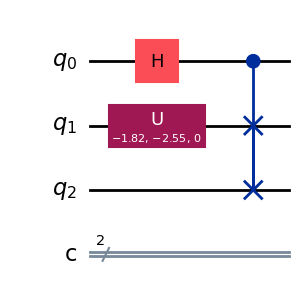

In [5]:
build_circuit(*states[0]).draw('mpl')

In [6]:
def add_basis_meas(circuit, qubit, meas_qubits, meas_clbits, basis='z') -> QuantumCircuit:
    circ = circuit.copy()
    circ.barrier()

    if basis == 'x':
        circ.h(qubit)
    elif basis == 'y':
        circ.sdg(qubit)
        circ.h(qubit)

    circ.measure(meas_qubits, meas_clbits)

    return circ


# Create named tuple object, for easy indexing, e.g. ".x", instead of "[0]"
TomographySet = namedtuple('TomographySet', ['x', 'y', 'z'])


def get_tomography_circuits(circuit, qubit, meas_qubits, meas_clbits) -> list[QuantumCircuit]:
    return [
        add_basis_meas(circuit, qubit, meas_qubits, meas_clbits, 'x'),
        add_basis_meas(circuit, qubit, meas_qubits, meas_clbits, 'y'),
        add_basis_meas(circuit, qubit, meas_qubits, meas_clbits, 'z')
    ]

In [7]:
get_tomography_circuits(build_circuit(*states[0]), 2, [0, 2], [0, 1])[0].draw()

┌───┐              ░      ┌─┐   
q_0: ─────────┤ H ├───────────■──░──────┤M├───
     ┌────────┴───┴─────────┐ │  ░      └╥┘   
q_1: ┤ U(-1.8151,-2.5482,0) ├─X──░───────╫────
     └──────────────────────┘ │  ░ ┌───┐ ║ ┌─┐
q_2: ─────────────────────────X──░─┤ H ├─╫─┤M├
                                 ░ └───┘ ║ └╥┘
c: 2/════════════════════════════════════╩══╩═
                                         0  1

In [8]:
def generate_tomography_sets(theta, phi) -> list[list[QuantumCircuit]]:
    return [ 
        *get_tomography_circuits(
            build_circuit(theta, phi), 1, [0, 1], [0, 1]
        ),
        *get_tomography_circuits(
            build_circuit(theta, phi), 2, [0, 2], [0, 1]
        )
    ]

In [9]:
ibm_brisbane = service.get_backend('ibm_brisbane')

In [10]:
circuits_to_send = list(itertools.chain.from_iterable([
        circuit for circuit in [
            itertools.chain.from_iterable(generate_tomography_sets(theta, phi) for theta, phi in states)
        ]
    ]
))

circuits_to_send = [transpile(circuit, ibm_brisbane) for circuit in circuits_to_send]

In [11]:
def get_all_physical_qubits(circuit_list: list[QuantumCircuit]) -> set[int]:
    all_indices = set()
    for circ in circuit_list:    
        measurement_indices = [instr[1][0]._index for instr in circ.data if instr[0].name == 'measure']
        all_indices = all_indices.union(measurement_indices)
    return all_indices


def get_mitigation_circuits(circuit_list: list[QuantumCircuit]) -> list[QuantumCircuit]:

    physical_qubits = get_all_physical_qubits(circuit_list)

    num_qubits = len(physical_qubits)
    all_0 = QuantumCircuit(127, num_qubits)
    all_0.measure(physical_qubits, range(num_qubits))

    all_1 = QuantumCircuit(127, num_qubits)
    all_1.x(physical_qubits)
    all_1.measure(physical_qubits, range(num_qubits))

    return [all_0, all_1]

In [12]:
circuits_to_send = get_mitigation_circuits(circuits_to_send) + circuits_to_send

In [13]:
hardware_job = ibm_brisbane.run(circuits=circuits_to_send)

In [14]:
print(f"Hardware job ID: {hardware_job.job_id()}")

Hardware job ID: cw6c2e1xa9wg008wc1ag


---

In [15]:
results = hardware_job.result().get_counts()

In [17]:
results

[{'010': 20, '101': 1, '100': 48, '000': 3870, '001': 61},
 {'110': 56, '101': 37, '111': 3872, '100': 2, '011': 33},
 {'11': 1044, '10': 169, '00': 1782, '01': 1005},
 {'11': 977, '10': 671, '01': 1032, '00': 1320},
 {'11': 102, '10': 1117, '00': 829, '01': 1952},
 {'11': 195, '10': 966, '00': 984, '01': 1855},
 {'01': 1187, '10': 956, '00': 939, '11': 918},
 {'01': 813, '10': 81, '00': 1862, '11': 1244},
 {'01': 970, '10': 840, '00': 1170, '11': 1020},
 {'00': 1325, '10': 630, '01': 1088, '11': 957},
 {'11': 81, '10': 1750, '00': 194, '01': 1975},
 {'11': 892, '10': 968, '00': 940, '01': 1200},
 {'00': 960, '10': 926, '01': 1317, '11': 797},
 {'01': 187, '10': 108, '00': 1848, '11': 1857},
 {'11': 990, '10': 122, '01': 1012, '00': 1876},
 {'11': 966, '10': 1015, '01': 1058, '00': 961},
 {'00': 741, '10': 1173, '01': 2011, '11': 75},
 {'11': 265, '10': 967, '00': 964, '01': 1804},
 {'11': 1271, '10': 975, '00': 977, '01': 777},
 {'11': 1362, '10': 93, '01': 720, '00': 1825}]

In [36]:
def get_combined_xyz_counts_for_circuit(counts_list: list) -> tuple[dict]:

    output_qubit_1 = []
    for counts in counts_list[0:3]:
        counts_dict = {}

        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string == '00')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string == '10')

        output_qubit_1.append(counts_dict)

    output_qubit_2 = []
    for counts in counts_list[3:6]:
        counts_dict = {}
        
        counts_dict['0'] = sum(count for bit_string, count in counts.items() if bit_string == '01')
        counts_dict['1'] = sum(count for bit_string, count in counts.items() if bit_string == '11')        

        output_qubit_2.append(counts_dict)

    output = (add_dicts(dict_1, dict_2) for dict_1, dict_2 in zip(output_qubit_1, output_qubit_2))   
    
    return tuple(output)


def print_unmitigated_fidelities_combined(counts, theta, phi):

    qubit = density_op_from_counts_dict(*get_combined_xyz_counts_for_circuit(counts))

    print(get_combined_xyz_counts_for_circuit(counts))
    print(qubit)

    psi = gen_qubit(theta, phi)

    fidelity_q = state_fidelity(qubit, psi)

    print(f'State fidelity from combined counts: {fidelity_q}\n')

In [37]:
print_unmitigated_fidelities_combined(results[2:8], *states[0])
print_unmitigated_fidelities_combined(results[8:14], *states[1])
print_unmitigated_fidelities_combined(results[14:20], *states[2])

({'0': 3637, '1': 364}, {'0': 2507, '1': 1589}, {'0': 1642, '1': 2361})
[[0.41 +0.j    0.409-0.112j]
 [0.409+0.112j 0.59 +0.j   ]]
State fidelity from combined counts: 0.9115511712085627

({'0': 2370, '1': 1732}, {'0': 2642, '1': 1427}, {'0': 381, '1': 3607})
[[0.096+0.j    0.078-0.149j]
 [0.078+0.149j 0.904+0.j   ]]
State fidelity from combined counts: 0.937205478150258

({'0': 3680, '1': 387}, {'0': 1738, '1': 2286}, {'0': 1461, '1': 2535})
[[0.366+0.j    0.405+0.068j]
 [0.405-0.068j 0.634+0.j   ]]
State fidelity from combined counts: 0.91378365665942



In [38]:
# Gets the map from a physical qubit to a classical bit for the mitigation calibration matrices
def get_qubit_to_clbit_mappings_for_mitigation(circuit: QuantumCircuit) -> dict[int, int]:
    return dict(
        ((instr[1][0]._index, instr[2][0]._index) for instr in circuit.data if instr[0].name == 'measure')
    )

# Gets the map from physical qubit to mitigation matrix
def get_assignment_matrices(mappings: dict, counts_0: dict, counts_1: dict) -> dict[int, ndarray]:

    output = {}

    for physical_qubit, classical_bit in mappings.items():
        
        # Determine zero state for assignment matrix
        result_0 = sum([count for bit_string, count in counts_0.items() if bit_string[classical_bit] == '0'])
        result_1 = sum([count for bit_string, count in counts_0.items() if bit_string[classical_bit] == '1'])
        
        # Calculate zero ket
        zero_ket = array([[result_0], 
                          [result_1]]) / (result_0 + result_1)
        
        # Determine one state for assignment matrix
        result_0 = sum([count for bit_string, count in counts_1.items() if bit_string[classical_bit] == '0'])
        result_1 = sum([count for bit_string, count in counts_1.items() if bit_string[classical_bit] == '1'])
        
        # Calculate zero ket
        one_ket = array([[result_0], 
                         [result_1]]) / (result_0 + result_1)
        
        assignment_matrix = numpy.concatenate([zero_ket, one_ket], axis=1)

        output[physical_qubit] = assignment_matrix
    
    return output

# Get the list of physical qubits in the same order as the classical bits 
def get_qubits_in_clbit_order(circuit: QuantumCircuit) -> list[int]:
    
    cl_bit_to_qbit_map = dict((instr[2][0]._index, instr[1][0]._index) for instr in circuit.data if instr[0].name == 'measure')

    return [*cl_bit_to_qbit_map.values()]
    

# Get the tensor of all mitigation matrices in the correct order for each circuit
def get_mitigation_matrix(circuit: QuantumCircuit, assignment_mappings: dict) -> ndarray:
    ordered_physical_qubits = get_qubits_in_clbit_order(circuit)

    ordered_physical_qubits.reverse()

    assignment_matrices = [assignment_mappings[qubit] for qubit in ordered_physical_qubits]

    return tens(*(scipy.linalg.inv(mat) for mat in assignment_matrices))


def get_bit_strings(count: int) -> list[str]:
    return [''.join(bits) for bits in itertools.product(['0', '1'], repeat=count)]


def get_corrected_counts(circuit: QuantumCircuit, counts_for_mitigation: dict, assignment_mappings: dict, num_qubits: int) -> dict[str, int]:
    bit_strings = get_bit_strings(num_qubits)

    counts_list = []
    for bit_string in bit_strings:
        counts_list.append(counts_for_mitigation[bit_string] if bit_string in counts_for_mitigation else 0)
    
    # Get vector of counts
    counts_vector = numpy.concatenate(
        array([[count for count in counts_list]]),
        axis=0
    )

    mitigation_matrix = get_mitigation_matrix(circuit, assignment_mappings)
    
    # Multiply by mitigation matirx
    corrected_vector = mitigation_matrix @ counts_vector
    corrected_vector = corrected_vector.astype(int)
    
    output = {}
    for idx, bit_string in zip(range(2**num_qubits), bit_strings):
        output[bit_string] = int(corrected_vector[idx])
    
    return output

In [39]:
# Get list of qubit to clbit mappings for the mitigation circuits.
mitigation_mappings = get_qubit_to_clbit_mappings_for_mitigation(circuits_to_send[0])

# Calculate assignment matrices for each qubit. 
assignment_matrices = get_assignment_matrices(mitigation_mappings, results[0], results[1])

In [40]:
def print_mitigated_fidelities_combined(circuits, counts, assignment_matrices, num_qubits, theta, phi):

    mitigated_counts = []

    for circuit, count in zip(circuits, counts):
        mitigated_counts.append(get_corrected_counts(circuit, count, assignment_matrices, num_qubits))

    qubit = density_op_from_counts_dict(*get_combined_xyz_counts_for_circuit(mitigated_counts))
    
    print(get_combined_xyz_counts_for_circuit(mitigated_counts))
    print(qubit)

    psi = gen_qubit(theta, phi)

    fidelity_q = state_fidelity(qubit, psi)

    print(f'Mitigated state fidelity from combined counts: {fidelity_q}\n')

In [42]:
print_mitigated_fidelities_combined(circuits_to_send[2:8], results[2:8], assignment_matrices, 2, *states[0])
print_mitigated_fidelities_combined(circuits_to_send[8:14], results[8:14], assignment_matrices, 2, *states[1])
print_mitigated_fidelities_combined(circuits_to_send[14:20], results[14:20], assignment_matrices, 2, *states[2])

({'0': 3688, '1': 311}, {'0': 2517, '1': 1579}, {'0': 1605, '1': 2396})
[[0.401+0.j    0.422-0.115j]
 [0.422+0.115j 0.599+0.j   ]]
Mitigated state fidelity from combined counts: 0.9256879672808636

({'0': 2378, '1': 1725}, {'0': 2657, '1': 1411}, {'0': 303, '1': 3683})
[[0.076+0.j    0.08 -0.153j]
 [0.08 +0.153j 0.924+0.j   ]]
Mitigated state fidelity from combined counts: 0.9568845797294552

({'0': 3731, '1': 336}, {'0': 1722, '1': 2300}, {'0': 1418, '1': 2576})
[[0.355+0.j    0.417+0.072j]
 [0.417-0.072j 0.645+0.j   ]]
Mitigated state fidelity from combined counts: 0.9285801340386098

